In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table, join, unique

### Get Gaia counterparts for every candidate Kepler host star:

In [3]:
kepler_hosts = Table(np.genfromtxt('../cumulative_all.csv', 
                                   delimiter=',', skip_header=150, names=True,
                                   dtype=None, encoding=None))

In [4]:
gaia_20arcsec = Table.read('/Users/mbedell/Documents/Web Design/gaia-kepler.fun/scripts/kepler_dr2_20arcsec.fits')

In [5]:
hosts = join(kepler_hosts, gaia_20arcsec, keys='kepid')

In [6]:
hosts.sort(['kepid','kepler_gaia_ang_dist'])

In [7]:
hosts[hosts['kepid'] == 5164794]['kepmag','phot_g_mean_mag','kepler_gaia_ang_dist',
                                 'pmra','pmdec','bp_rp', 'koi_gmag',
 'koi_rmag',
 'koi_imag',
 'koi_zmag',
 'koi_jmag',
 'koi_hmag',
 'koi_kmag']

kepmag,phot_g_mean_mag,kepler_gaia_ang_dist,pmra,pmdec,bp_rp,koi_gmag,koi_rmag,koi_imag,koi_zmag,koi_jmag,koi_hmag,koi_kmag
,mag,arcsec,0.001 arcsec / yr,0.001 arcsec / yr,mag,,,,,,,
float64,float32,float64,float64,float64,float32,float64,float64,float64,float64,float64,float64,float64
11.51,13.785815,15.49428911401206,-0.4286952372334374,12.600345434454887,1.0473557,0.0,11.51,0.0,nan,12.415,12.045,11.955
11.51,19.832888,16.551936866809164,-3.0211833315066787,0.11251195089681369,0.61762047,0.0,11.51,0.0,nan,12.415,12.045,11.955
11.51,21.127596,17.163570606547726,nan,nan,nan,0.0,11.51,0.0,nan,12.415,12.045,11.955


In [8]:
match = hosts[hosts['kepid'] == 5164794]
from astropy.coordinates import SkyCoord
from astropy import units as u
c1 = SkyCoord(match['ra_1']*u.deg, match['dec_1']*u.deg)
c2 = SkyCoord(match['ra_2'], match['dec_2'])
c1.separation(c2)

<Angle [0.00434726, 0.00460957, 0.00476766] deg>

#### Cut matches that probably aren't the correct star:

In [9]:
#bad_kmag = np.abs(hosts['kepmag'] - hosts['koi_gmag']) > 2.
#good = np.where(bad_kmag, np.abs(hosts['phot_g_mean_mag'] - hosts['koi_gmag']) <= 2.,
#                          np.abs(hosts['phot_g_mean_mag'] - hosts['kepmag']) <= 2.)
#hosts = hosts[good]

In [10]:
good = (np.abs(hosts['phot_g_mean_mag'] - hosts['kepmag']) <= 5.) & (hosts['kepler_gaia_ang_dist'] < 5.)
#good = hosts['kepler_gaia_ang_dist'] < 5.
hosts = hosts[good]

/Users/mbedell/miniconda3/lib/python3.7/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less_equal
  return getattr(self.data, op)(other)


In [11]:
#hosts = unique(hosts, keys='kepid', keep='first') # cut duplicate matches, keeping closest star

/Users/mbedell/miniconda3/lib/python3.7/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)


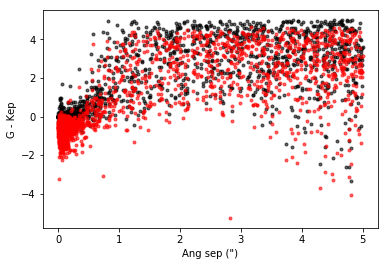

In [12]:
plt.plot(hosts['kepler_gaia_ang_dist'], hosts['phot_g_mean_mag'] - hosts['kepmag'], 'k.', alpha=0.6)
mask = hosts['koi_gmag'] > 0.
plt.plot(hosts['kepler_gaia_ang_dist'][mask], 
         hosts['phot_g_mean_mag'][mask] - hosts['koi_gmag'][mask], 'r.', alpha=0.6)
#plt.ylim([-0.5,1.0])
plt.xlabel('Ang sep (")')
plt.ylabel('G - Kep');

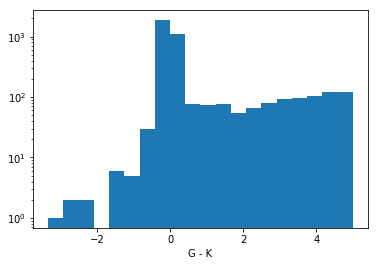

In [13]:
plt.hist((hosts['phot_g_mean_mag'] - hosts['kepmag'])[np.isfinite(hosts['phot_g_mean_mag'])], bins=20)
plt.yscale('log')
plt.xlabel('G - K');

#### Check on some statistics for how many stars have believable matches:

In [14]:
print("Number of candidate host stars:", len(kepler_hosts['kepid']))

Number of candidate host stars: 3100


In [15]:
no_match_kics = kepler_hosts[np.isin(kepler_hosts['kepid'], hosts['kepid'], invert=True)]['kepid']
match_kics, counts = np.unique(hosts['kepid'], return_counts=True)
multi_match_kics = match_kics[counts > 1]
single_match_kics = match_kics[counts == 1]

In [16]:
print("Number of candidate host stars without Gaia counterparts:", len(no_match_kics))
print("Number of candidate host stars with more than one close Gaia match:", len(multi_match_kics))

Number of candidate host stars without Gaia counterparts: 15
Number of candidate host stars with more than one close Gaia match: 773


#### Check on stars where we found more than one good match:

In [17]:
t = hosts[np.isin(hosts['kepid'], multi_match_kics)]['kepid', 'kepmag', 
                                                     'phot_g_mean_mag', 'kepler_gaia_ang_dist', 'bp_rp']

In [18]:
t

kepid,kepmag,phot_g_mean_mag,kepler_gaia_ang_dist,bp_rp
,,mag,arcsec,mag
int64,float64,float32,float64,float32
1161345,11.631,12.395216,0.704873697981034,1.0328989
1161345,11.631,12.499258,1.0614467549508892,nan
1575690,15.625,15.653265,0.08095205248777011,1.6652098
1575690,15.625,18.987381,3.8620329442734076,1.9336071
1717722,15.689,15.65396,0.12864722890493463,1.3381376
1717722,15.689,20.383476,4.282989568934901,0.8737469
1870398,14.756,14.734896,0.03675243955959094,0.86446
1870398,14.756,19.200357,4.243557722952917,1.1516876


In [19]:
#t.show_in_browser(jsviewer=True)  

In general these seem to be unresolved binaries in Kepler that have been resolved by Gaia. We can therefore keep either star to adopt as the "true match." The cross-match table is already sorted by angular distance between the Kepler coordinates and the Gaia match, so let's adopt that as the deciding factor.

In [20]:
hosts = unique(hosts, keys='kepid', keep='first')

#### Check on stars without Gaia counterparts:

In [21]:
t2 = kepler_hosts[np.isin(kepler_hosts['kepid'], no_match_kics)]['kepid', 'kepler_name', 'koi_kepmag', 
                                                                 'koi_gmag', 'ra', 'dec',
                                                                 'koi_period', 'koi_prad', 'koi_disposition']

In [22]:
t2

kepid,kepler_name,koi_kepmag,koi_gmag,ra,dec,koi_period,koi_prad,koi_disposition
int64,str13,float64,float64,float64,float64,float64,float64,str14
5389540,0.0,13.259,13.846,298.46799,40.516678,10.26231992,1.98,FALSE POSITIVE
10264660,Kepler-14 b,12.128,12.363,287.70883,47.33305,6.790120801,9.86,CONFIRMED
3742855,0.0,13.133,13.14,290.26614,38.837917,6.397185875,15.02,FALSE POSITIVE
10287248,0.0,13.987,14.839,296.69562,47.327309,4.722254104,14.45,FALSE POSITIVE
2438061,0.0,0.0,0.0,290.27701,37.79097,2.442941283,48.18,FALSE POSITIVE
5952366,0.0,13.38,0.0,289.27658,41.259754,0.905679492,35.74,FALSE POSITIVE
2970804,0.0,9.16,0.0,286.10696,38.107628,0.686994057,35.3,FALSE POSITIVE
9644411,0.0,14.785,15.527,289.87915,46.322498,0.379412331,1.59,FALSE POSITIVE
7284688,0.0,11.234,12.702,292.63,42.829338,0.323021692,46.4,FALSE POSITIVE


In [23]:
#t2.show_in_browser(jsviewer=True)  

In [24]:
t2.write('unmatched_kics.csv', overwrite=True)

#### Of the stars with decent matches, keep only the ones with well-measured parallax & PM:

In [25]:
has_plx = np.isfinite(hosts['parallax'])
hosts = hosts[has_plx] # cut stars without 5-param DR2 solutions
print("{0} sources cut for not having a 5-parameter solution.".format(np.sum(~has_plx)))

46 sources cut for not having a 5-parameter solution.


In [26]:
bab_cuts =  (hosts['visibility_periods_used'] > 8) & \
            (hosts['astrometric_chi2_al']/(hosts['astrometric_n_good_obs_al'] - 5) < 
             1.44*np.nanmax(np.vstack([np.ones_like(hosts['phot_g_mean_mag']), 
                    np.exp(-0.4*(hosts['phot_g_mean_mag']-19.5))]), axis=0))
hosts = hosts[bab_cuts] # cut stars without much data or with poor astrometric fits
print("{0} sources cut following Babusiaux recommended solution quality cuts.".format(np.sum(~bab_cuts)))

182 sources cut following Babusiaux recommended solution quality cuts.


In [27]:
high_snr = hosts['parallax_over_error'] > 5.
hosts = hosts[high_snr] # cut stars with poorly measured parallax
print("{0} sources cut for low SNR.".format(np.sum(~high_snr)))

98 sources cut for low SNR.


In [31]:
bright = hosts['phot_g_mean_mag'] <= 18.
hosts = hosts[bright] # cut faint stars
print("{0} sources cut for faintness.".format(np.sum(~bright)))

1 sources cut for faintness.


In [28]:
# Cut these?
nonzero_pm = (np.sqrt(hosts['pmra']**2 + 
                      hosts['pmdec']**2)/np.sqrt(hosts['pmra_error']**2 + 
                      hosts['pmdec_error']**2) > 5.) 
#hosts = hosts[nonzero_pm]
print("{0} sources have little proper motion; keeping them for now.".format(np.sum(~nonzero_pm)))
#hosts[~nonzero_pm]

7 sources have little proper motion; keeping them for now.


In [32]:
print("In total, {0} of {1} Kepler host star candidates have good Gaia DR2 counterparts.".format(len(hosts),
                                                                                                len(kepler_hosts)))

In total, 2758 of 3100 Kepler host star candidates have good Gaia DR2 counterparts.


In [33]:
hosts.write('kepler_host_matches.fits', overwrite=True)